# Goal

Prevent a credit card fraud: when a bad actor uses someone else's credit card information to make a purchase without their permission.

**Columns**:
- **distance_from_home** - the distance from home where the transaction happened.
- **distance_from_last_transaction** - the distance from last transaction happened.
- **ratio_to_median_purchase_price** - Ratio of purchased price transaction to median purchase price.
- **repeat_retailer** - Is the transaction happened from same retailer.
- **used_chip** - Is the transaction through chip (credit card).
- **used_pin_number** - Is the transaction happened by using PIN number.
- **online_order** - Is the transaction an online order.
- **fraud** - Is the transaction fraudulent. This is what we're trying to predict.

# Imports

## libraries

In [39]:
# number crunching
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import StandardScaler

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# validation
from sklearn.model_selection import cross_val_score, KFold



In [41]:
# Pip 21.3+ is required
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/03/e6/4aef6799badc2693548559bad5b56d56cfe89eada337c815fdfe92175250/xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.2 MB/s eta 0:00:00a 0:00:01


In [42]:
from xgboost import XGBClassifier

## data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

---

# Exploratory Data Analysis 

## General

In [3]:
train.shape, test.shape

((18000, 9), (2000, 8))

In [4]:
train.isnull().sum()

id                                0
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [5]:
test.isnull().sum()

id                                0
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
dtype: int64

In [6]:
train

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0
2,19872,5.740898,0.167525,3.969652,1.0,0.0,0.0,1.0,0
3,18763,4.098570,0.291850,0.084129,1.0,1.0,0.0,1.0,1
4,13547,7.539580,0.294439,2.890880,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
17995,11193,8.191938,0.295913,1.011287,1.0,0.0,0.0,1.0,0
17996,10245,10.098491,1.042468,3.073815,1.0,0.0,0.0,1.0,0
17997,5660,2.826653,0.093371,0.047923,1.0,1.0,0.0,0.0,0
17998,10839,0.826856,0.164881,2.827485,0.0,0.0,0.0,1.0,0


In [7]:
train_index = len(train)-1
test_index = len(train)
train_index, test_index

(17999, 18000)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18000 non-null  int64  
 1   distance_from_home              18000 non-null  float64
 2   distance_from_last_transaction  18000 non-null  float64
 3   ratio_to_median_purchase_price  18000 non-null  float64
 4   repeat_retailer                 18000 non-null  float64
 5   used_chip                       18000 non-null  float64
 6   used_pin_number                 18000 non-null  float64
 7   online_order                    18000 non-null  float64
 8   fraud                           18000 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.2 MB


In [9]:
train.describe()

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,10004.217000,9.634483,1.194058,1.098892,0.928556,0.294222,0.047611,0.701222,0.086000
std,5777.289102,9.635835,2.642941,1.272369,0.257789,0.458379,0.220384,0.457735,0.280372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5017.750000,2.924786,0.144539,0.335077,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9994.500000,6.181911,0.436769,0.764678,1.000000,0.000000,0.000000,1.000000,0.000000
75%,15005.250000,12.882383,1.073838,1.420102,1.000000,1.000000,0.000000,1.000000,0.000000
max,19999.000000,62.099289,51.653566,28.341698,2.000000,7.000000,8.000000,1.000000,1.000000


### distance from home

In [10]:
train.distance_from_home.nunique()

17993

In [11]:
train.distance_from_home.unique()

array([ 3.34686958, 14.48286751,  5.74089849, ...,  2.8266535 ,
        0.82685643,  3.7350089 ])

In [12]:
train.distance_from_home.value_counts()

distance_from_home
0.000000     4
8.000000     2
3.000000     2
1.000000     2
7.000000     2
            ..
16.937881    1
5.743241     1
2.686027     1
1.403830     1
3.735009     1
Name: count, Length: 17993, dtype: int64

<Axes: xlabel='distance_from_home', ylabel='Count'>

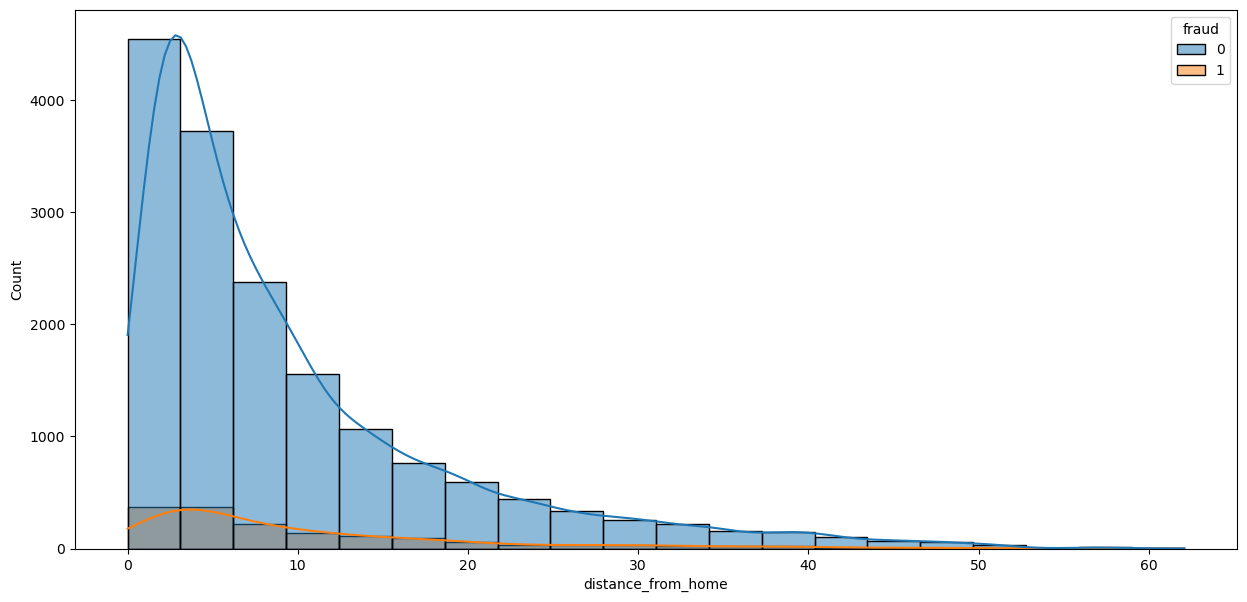

In [13]:
plt.figure(figsize=(15,7))
sns.histplot(train, bins=20, x="distance_from_home", hue="fraud", kde=True)

### my opinion
I can be wrong but for me look like that the amount of fraude is tight to amount of transaction. In other words, even though the great amount of fraud is next to the home of the person we also can see that is the greatest amount of transaction as well.

### distance_from_last_transaction

In [14]:
train.distance_from_last_transaction.nunique()

17965

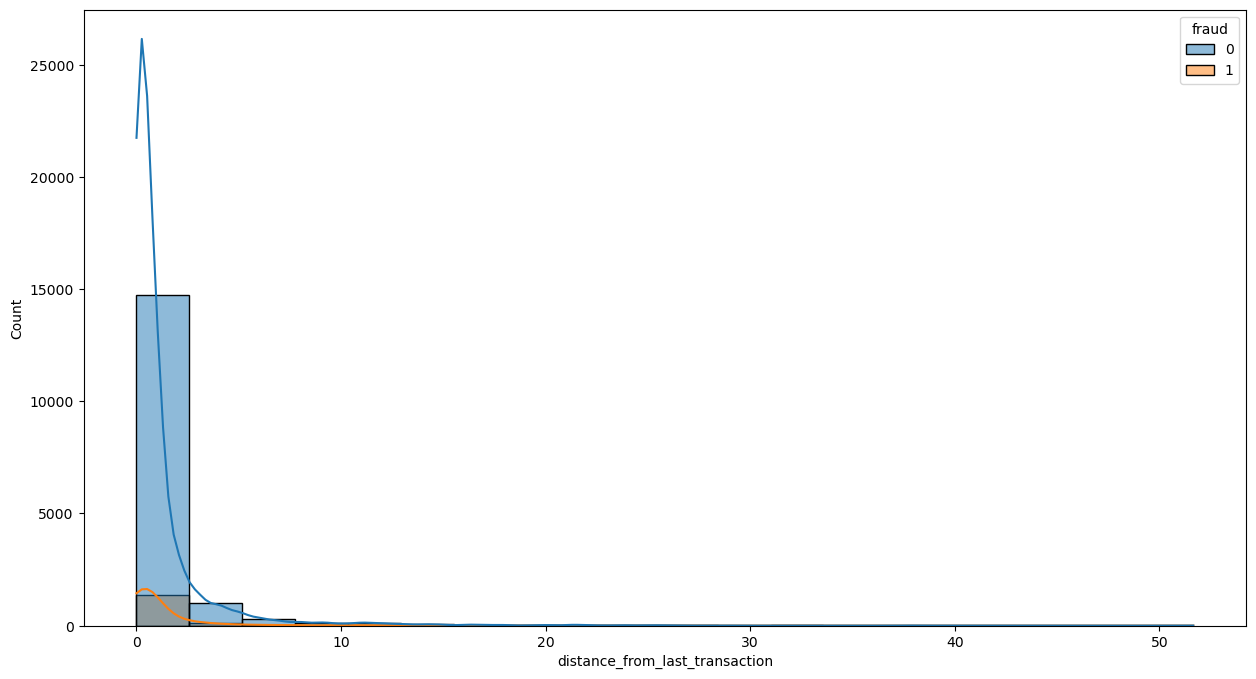

In [15]:
plt.figure(figsize=(15,8))
sns.histplot(train, x="distance_from_last_transaction", hue="fraud", kde=True, bins=20);

### my opinion
The same as the distance_from_home column

### ratio_to_median_purchase_price

In [16]:
train.head(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0


In [17]:
train.ratio_to_median_purchase_price.nunique()

17981

<Axes: xlabel='ratio_to_median_purchase_price', ylabel='Count'>

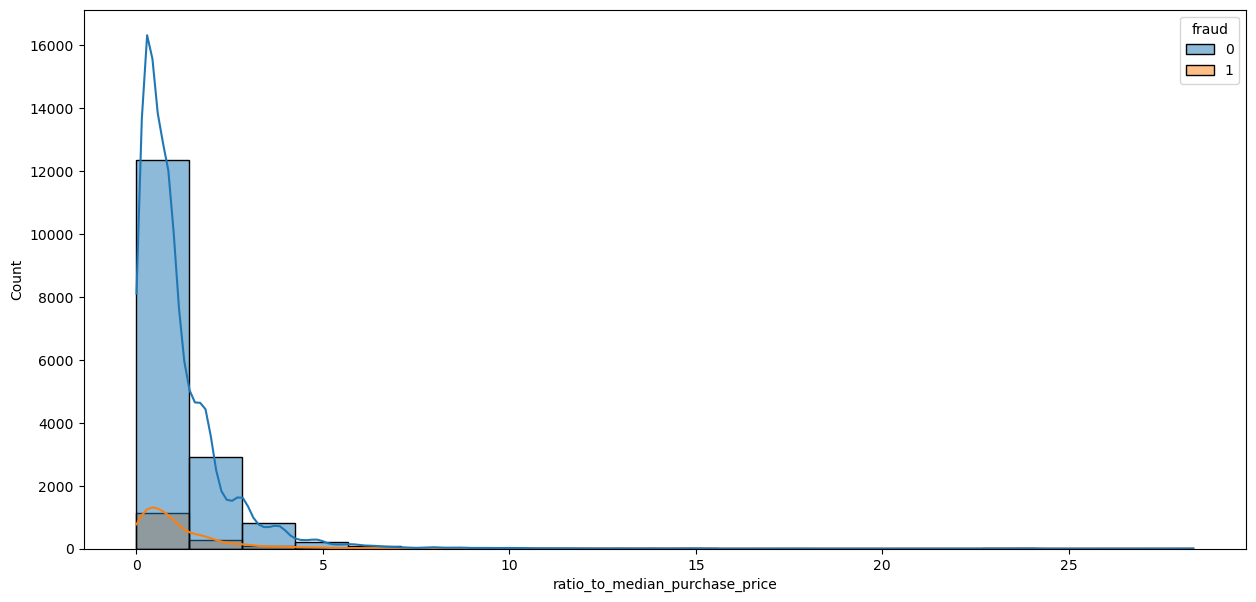

In [18]:
plt.figure(figsize=(15,7))
sns.histplot(train, x="ratio_to_median_purchase_price", kde=True, bins=20, hue="fraud")

In [19]:
train.ratio_to_median_purchase_price.duplicated().value_counts()

ratio_to_median_purchase_price
False    17981
True        19
Name: count, dtype: int64

### my opinion
the same as the distance_from_home column

### repeat_retailer

In [20]:
train.head(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0


In [21]:
train.repeat_retailer.nunique()

3

In [22]:
train.repeat_retailer.unique()

array([1., 0., 2.])

<Axes: xlabel='repeat_retailer', ylabel='count'>

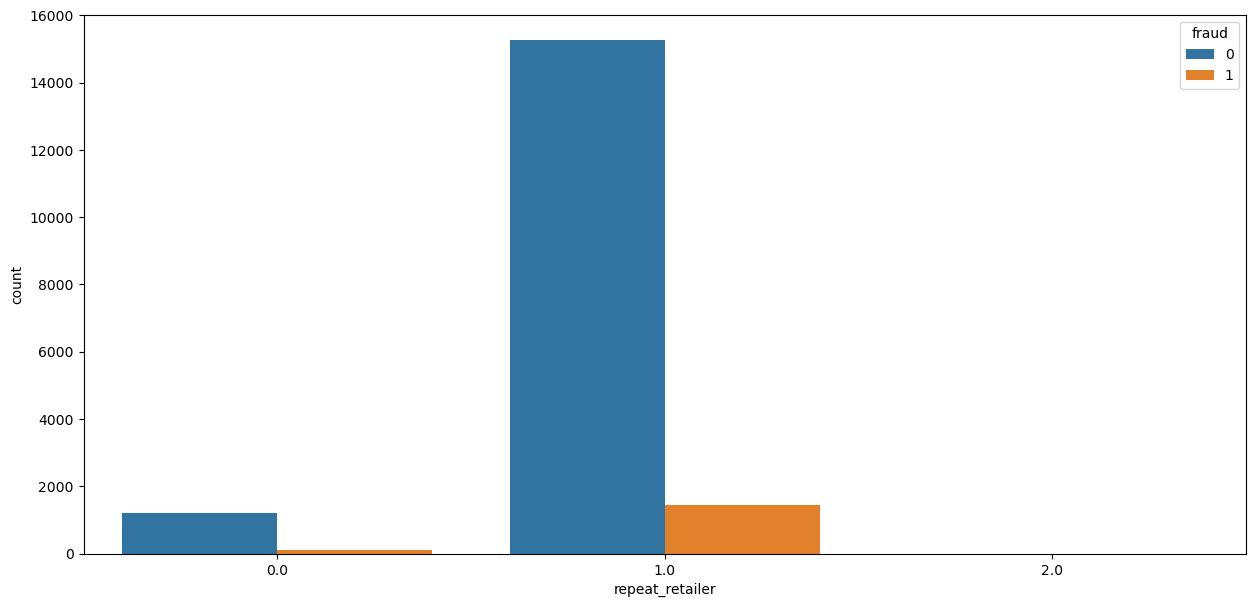

In [23]:
plt.figure(figsize=(15,7))
sns.countplot(train, x="repeat_retailer", hue="fraud")

### my opinion
Im not sure what this numbers 0, 1, and 2 are in this column. I need to find a way to interpret this. for now let keep moving. 

### used_chip

In [24]:
train.tail(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
17998,10839,0.826856,0.164881,2.827485,0.0,0.0,0.0,1.0,0
17999,5820,3.735009,0.067014,0.241356,1.0,0.0,0.0,1.0,0


<Axes: xlabel='used_chip', ylabel='count'>

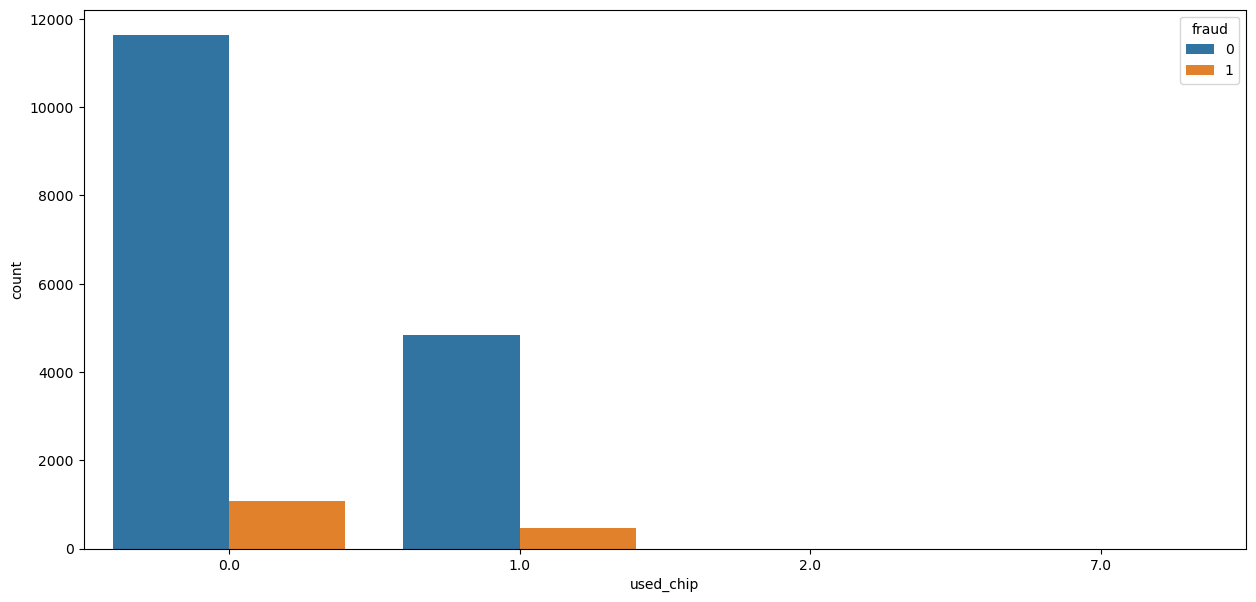

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(train, x="used_chip", hue="fraud")

### my opinion
The more the client uses credit card with chip the more fraud are

In [26]:
train.head(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0


### used_pin_number

<Axes: xlabel='used_pin_number', ylabel='count'>

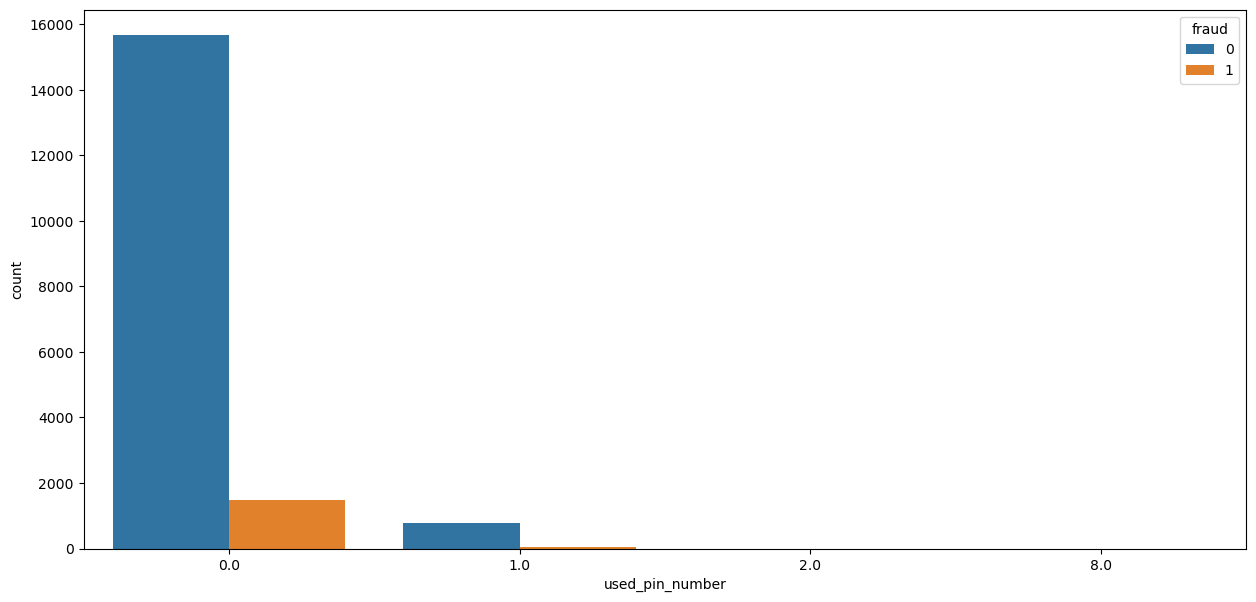

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.countplot(train, x="used_pin_number", hue="fraud")

### my opinion
I can't see any pattern so far

### online_order

<Axes: xlabel='online_order', ylabel='count'>

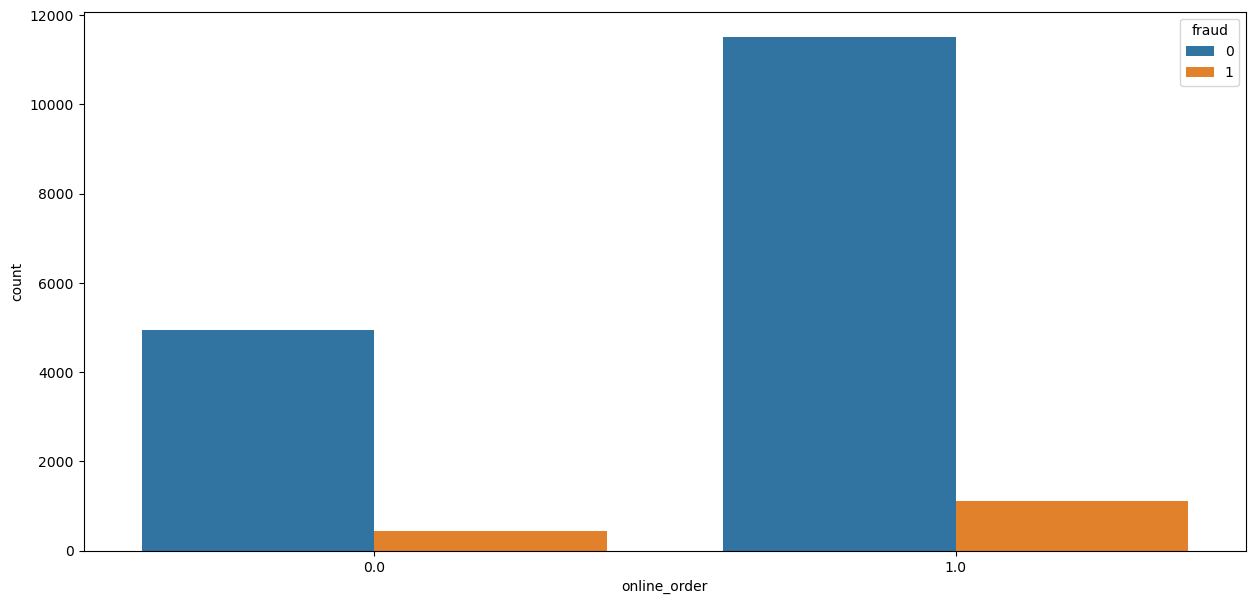

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(train, x="online_order", hue="fraud")

### my opinion
Any pattern so far for all columns

In [29]:
test.shape

(2000, 8)

# Preprocessing 

Apply normalization to:
> - distance_from_home
> - distance_from_last_transaction
> - ratio_to_median_purchase_price

In [30]:
## applying StardandScaler to the columns above
scaler = StandardScaler()

train[["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"]] = scaler.fit_transform(train[["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"]])
train

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,-0.652542,-0.217172,-0.120818,1.0,0.0,0.0,1.0,0
1,12430,0.503176,-0.387410,-0.011047,1.0,0.0,0.0,1.0,0
2,19872,-0.404085,-0.388416,2.256295,1.0,0.0,0.0,1.0,0
3,18763,-0.574529,-0.341375,-0.797560,1.0,1.0,0.0,1.0,1
4,13547,-0.217414,-0.340395,1.408426,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
17995,11193,-0.149710,-0.339837,-0.068854,1.0,0.0,0.0,1.0,0
17996,10245,0.048156,-0.057358,1.552205,1.0,0.0,0.0,1.0,0
17997,5660,-0.706531,-0.416475,-0.826017,1.0,1.0,0.0,0.0,0
17998,10839,-0.914074,-0.389417,1.358600,0.0,0.0,0.0,1.0,0


## split data manually

In [36]:
# train_label = train["fraud"]
# train_data = train.drop("fraud")
# train_data.shape, train_label.shape

train_label = train.fraud
train_label.shape

(18000,)

In [37]:
train_data = train.drop("fraud", axis=1)
train_data.shape

(18000, 8)

# Create the Models

## Naive Bayes